In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json
import os
plt.rcParams["figure.figsize"] = (25,10)

plt.rcParams.update({'font.size': 22})

colors='bgrykcm'
symbol='*-+^'

In [2]:
import Numerov
import utils
import numpy as np
import Atomic_Like_Potential as ALP
from Radial_Eigenfunction import Radial_Eigenfunction

In [3]:
#defining angular momentum and energy grids to look for eigenfunctions
angu_mome_grid=[0, 1, 2]
r_N_grid=[22.0]
ener_grid= -1.0*np.array(utils.get_exponential_grid(delta=0.001, max_valu=2.3, grid_points=20))

In [4]:
ener_grid

array([-0.        , -0.11391078, -0.22793553, -0.34207435, -0.45632738,
       -0.57069471, -0.68517647, -0.79977277, -0.91448372, -1.02930944,
       -1.14425005, -1.25930565, -1.37447636, -1.48976231, -1.60516359,
       -1.72068034, -1.83631266, -1.95206067, -2.06792449, -2.18390422])

In [5]:
#start kwargs with default values
kwargs={'delta_x': 0.001, 'r_N':18.0, 'l':0, 'Z':2.0, 'E':-0.5}
#inittial values of u function for integration routine
y_func=[1.8e-8, 2.0e-8] #[y(r_n), y(r_N-1)]

In [6]:
#for the r_N and angu_mome grids calcuate u(0,E)
#find the limits of the nodes for u(0,E) as function of E 
#the nodes limits are Ea and Eb. The eigenvalue E follows Ea < E < Eb
pote_eige_func=[]
for r_N in r_N_grid:
    kwargs['r_N']= r_N
    r_grid_reversed= utils.get_uniform_r_grid(**kwargs)
    S_atomic_radial= len(r_grid_reversed)*[0.0e-8]
    for l in angu_mome_grid:
        kwargs['l']= l
        
        u0_e=[]
        for E in ener_grid:
            kwargs['E']=E
            #print(kwargs)
            u_func, r_grid= Numerov.Numerov_backwards(y_func, r_grid_reversed, 
                                                      ALP.K2_atomic_radial,
                                                      S_atomic_radial,**kwargs)
            #print(u_func[0])
            u0_e.append(u_func[0])
        number_of_nodes, nodes_positions= utils.get_nodes_information(u0_e, ener_grid)
        #print(number_of_nodes)
        if number_of_nodes > 0:
            for elem in nodes_positions:
                pote_eige_func.append(Radial_Eigenfunction(Ea=elem[0],Eb=elem[1],**kwargs))

In [7]:
#plt.plot(ener_grid,u0_e, 'b*')
#plt.show()

In [8]:
#For every potential eigenfunction shrink the Ea, Eb segment
if len(pote_eige_func) > 0:
    for radi_eige_func in pote_eige_func:
        kwargs={'delta_x':radi_eige_func.delta_x, 'r_N':radi_eige_func.r_N, 
                'l':radi_eige_func.l, 'Z':radi_eige_func.Z, 'E':radi_eige_func.Ea}
        r_grid_reversed= utils.get_uniform_r_grid(**kwargs)
        while not radi_eige_func.check_if_eigenvalue():
            
            
            kwargs={'delta_x':radi_eige_func.delta_x, 'r_N':radi_eige_func.r_N, 
                    'l':radi_eige_func.l, 'Z':radi_eige_func.Z, 'E':radi_eige_func.Ea}
            
            u_func, r_grid= Numerov.Numerov_backwards(y_func, r_grid_reversed, 
                                                      ALP.K2_atomic_radial,
                                                      S_atomic_radial,**kwargs)
            u0a= u_func[0]
            
            kwargs={'delta_x':radi_eige_func.delta_x, 'r_N':radi_eige_func.r_N, 
                    'l':radi_eige_func.l, 'Z':radi_eige_func.Z, 'E':radi_eige_func.Eb}
            
            u_func, r_grid= Numerov.Numerov_backwards(y_func, r_grid_reversed, 
                                                      ALP.K2_atomic_radial,
                                                      S_atomic_radial,**kwargs)
            u0b= u_func[0]
            
            #E' is the candidate energy to shrink the energy segment
            Ep= utils.false_position(radi_eige_func.Ea,
                                     radi_eige_func.Eb,
                                     u0a,u0b)
            kwargs={'delta_x':radi_eige_func.delta_x, 'r_N':radi_eige_func.r_N, 
                    'l':radi_eige_func.l, 'Z':radi_eige_func.Z, 'E':Ep}
            u_func, r_grid= Numerov.Numerov_backwards(y_func, r_grid_reversed, 
                                                      ALP.K2_atomic_radial,
                                                      S_atomic_radial,**kwargs)
            u0p= u_func[0]
            #substitute Ep for either Ea or Eb
            if np.sign(u0p) == np.sign(u0a):
                radi_eige_func.Ea=Ep
            else:# np.sign(U0p) == np.sign(U0b):
                radi_eige_func.Eb=Ep
    for radi_eige_func in pote_eige_func:
        if radi_eige_func.E != None:
            kwargs={'delta_x':radi_eige_func.delta_x, 'r_N':radi_eige_func.r_N, 
                    'l':radi_eige_func.l, 'Z':radi_eige_func.Z, 'E':radi_eige_func.E}
            r_grid_reversed= utils.get_uniform_r_grid(**kwargs)
            u_func, r_grid= Numerov.Numerov_backwards(y_func, r_grid_reversed, 
                                                      ALP.K2_atomic_radial,
                                                      S_atomic_radial,**kwargs)
            radi_eige_func.set_u_function(u_func)
            radi_eige_func.set_r_grid(r_grid)
            radi_eige_func.bild_normalized_radi_eige_func()

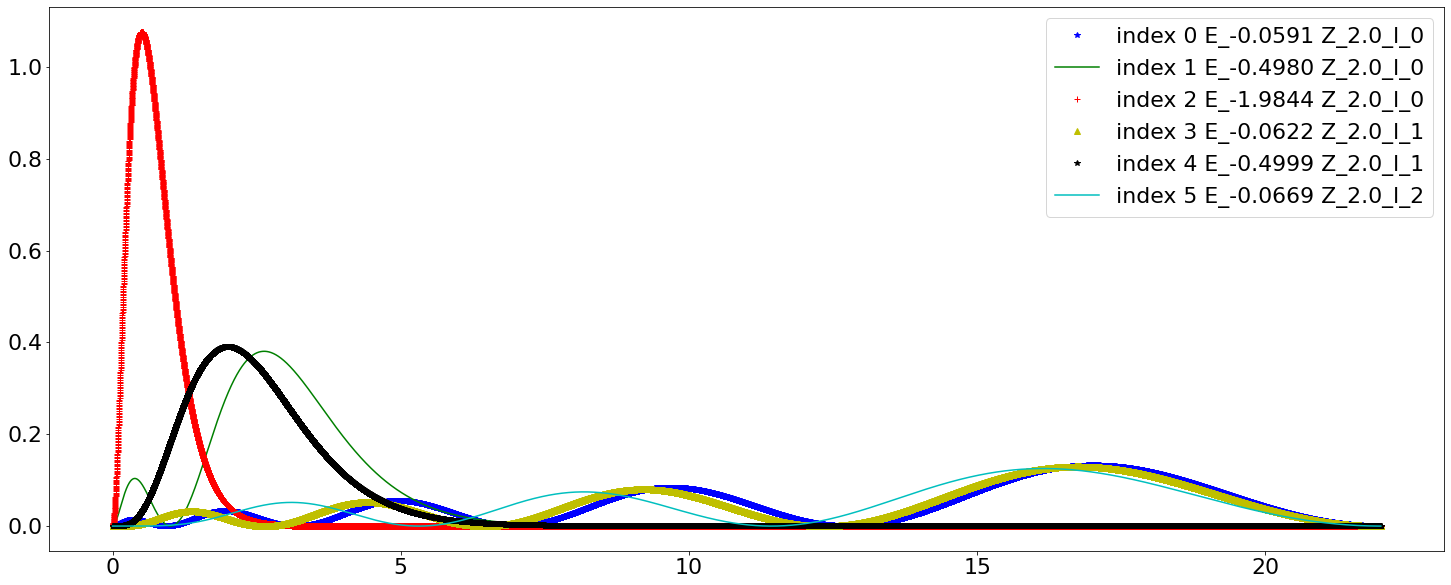

In [9]:
for i, radi_eige_func in enumerate(pote_eige_func):
    colo_symb=colors[i%len(colors)]+symbol[i%len(symbol)]
    label=f'index {i} E_{str(radi_eige_func.E)[:7]} Z_{radi_eige_func.Z}_l_{radi_eige_func.l}'
    plt.plot(radi_eige_func.r_grid,radi_eige_func.u_func**2,colo_symb,  label=label)
plt.legend()
plt.show()


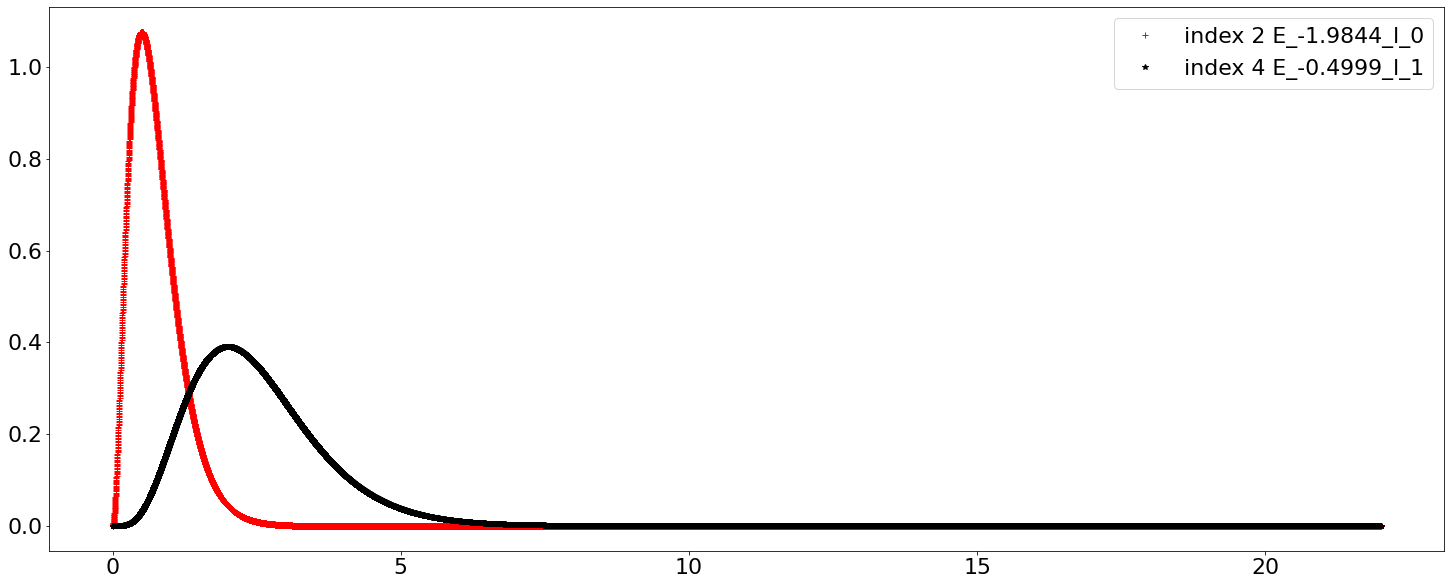

In [10]:
index_to_save=[2,4]
save_dir='wave_function_jsons'
for i in index_to_save:
    radi_eige_func= pote_eige_func[i]
    path=os.path.join(save_dir,
        f'Z_{radi_eige_func.Z}_E_{str(radi_eige_func.E)[:7]}_R_{str(radi_eige_func.r_N)[:3]}_l_{radi_eige_func.l}.json')
    radi_eige_func.save_as_json(path)
    colo_symb=colors[i%len(colors)]+symbol[i%len(symbol)]
    label=f'index {i} E_{str(radi_eige_func.E)[:7]}_l_{radi_eige_func.l}'
    plt.plot(radi_eige_func.r_grid,radi_eige_func.u_func**2,colo_symb,  label=label)
plt.legend()
plt.show()

average error  1.7638849264601366e-14


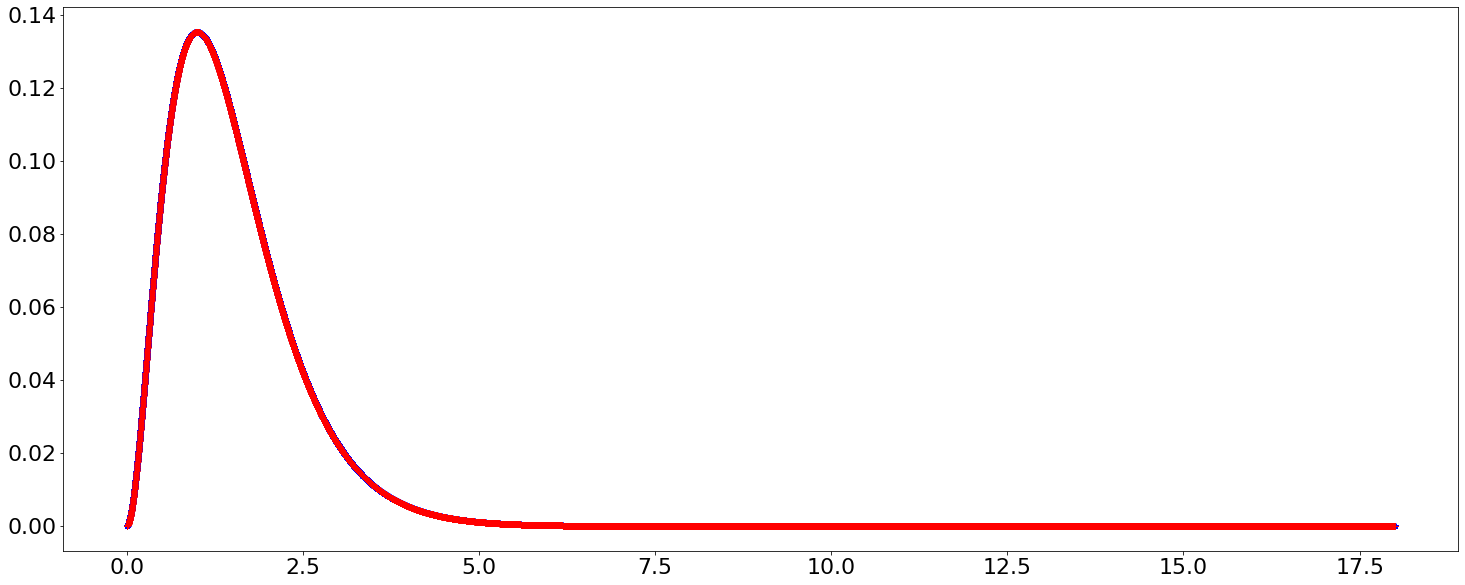

In [7]:
# for testing of Numerov with hydrogen base eigenstate
kwargs={'delta_x': 0.001, 'r_N':18.0, 'l':0, 'Z':1.0, 'E':-0.5}
r_grid_reversed= utils.get_uniform_r_grid(**kwargs)

u_hydr= utils.U_Hydrogen(r_grid_reversed)
y_func=[u_hydr[0], u_hydr[1]]

u_func, r_grid= Numerov.Numerov_backwards(y_func, r_grid_reversed, 
                                          ALP.K2_atomic_radial,
                                          S_atomic_radial,**kwargs)

print('average error ', np.average(np.subtract(np.flip(u_hydr)**2,u_func**2)))

plt.plot(r_grid,u_func**2,'b*', r_grid,np.flip(u_hydr)**2,'r+')
plt.show()